In [1]:
import sklearn
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib import pyplot as plt
from scipy import stats
import random
import math

!pip install emcee
import emcee

!pip install corner
import corner

!pip install dynesty
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

C:\Users\giuli\anaconda3\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


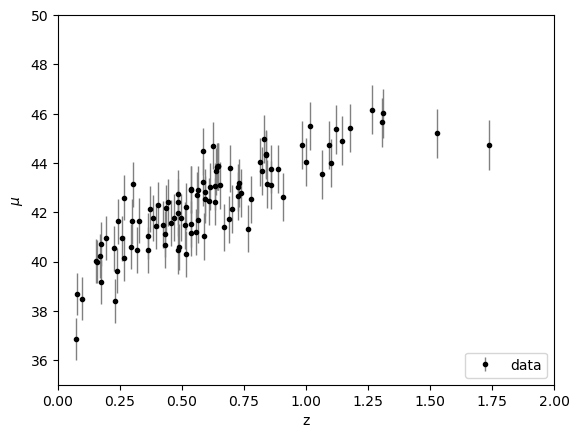

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) ###YOU CAN'T CHANGE THIS

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

In [3]:
def error(x,y,model):
    return np.sqrt(np.sum((y - model.predict(x))**2)/len(y))

def cross_GPR(data,labels,err,kernel):
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    train_err = []
    cross_err = []
    
    for train, test in kf.split(data):
        model =  GaussianProcessRegressor(kernel, alpha = err[train]**2)
        model.fit(data[train][:,np.newaxis],labels[train])
        train_err.append(error(data[train][:,np.newaxis],labels[train],model))
        cross_err.append(error(data[test][:,np.newaxis],labels[test],model))
        
    return np.sum(train_err)/len(train_err), np.sum(cross_err)/len(cross_err)

In [4]:
kernel = [kernels.RBF(),kernels.DotProduct(),kernels.RBF()*kernels.DotProduct(),kernels.ConstantKernel()*kernels.RBF()]
x_train, x_test, y_train, y_test, err_train, err_test = train_test_split(z_sample,mu_sample,dmu,train_size=0.9,random_state=42)
train_err = []
cross_err = []

for k in kernel:
    t, c = cross_GPR(x_train,y_train,err_train,k)
    train_err.append(t)
    cross_err.append(c)

best = np.array(kernel)[cross_err==np.min(cross_err)][0]
best

C:\Users\giuli\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\giuli\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\giuli\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\giuli\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: Converg

1**2 * RBF(length_scale=1)

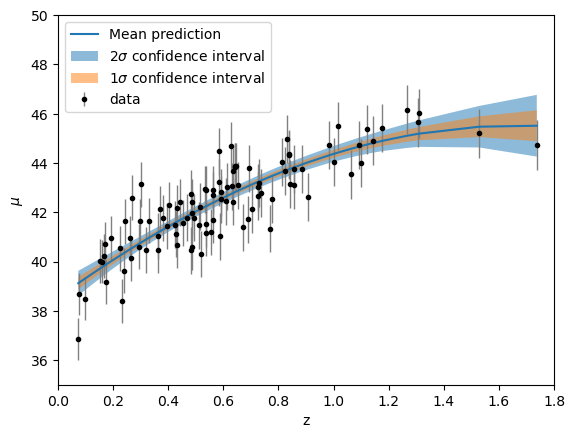

In [5]:
gp = GaussianProcessRegressor(kernel = best, alpha = dmu**2)
gp.fit(z_sample[:,np.newaxis], mu_sample)
y_pred, std_prediction = gp.predict(z_sample[:, np.newaxis], return_std=True)

#sort data to plot it
x, y, err = zip(*sorted(zip(z_sample,y_pred,std_prediction)))
x = np.array(x)
y = np.array(y)
err = np.array(err)

#plt.scatter(x1, y1, label="Observations")

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,1.8)
plt.ylim(35,50);

plt.plot(x, y, label="Mean prediction")
plt.fill_between(x, y - 2 * err, y + 2 * err, alpha=0.5, label=r"2$\sigma$ confidence interval")
plt.fill_between(x, y - err, y + err, alpha=0.5, label=r"1$\sigma$ confidence interval")
plt.legend()
plt.show()

# resample

We resample our dataset using inverse transform sampling.

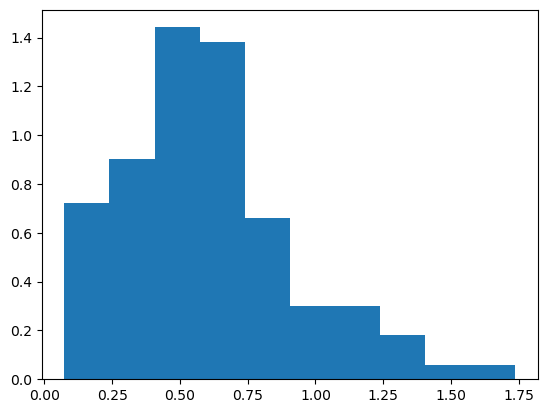

In [6]:
a,b,c = plt.hist(z_sample,density=True)

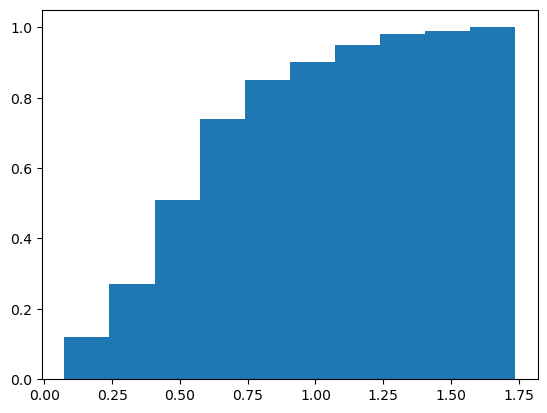

In [7]:
a1,b1,c1 = plt.hist(z_sample,density=True,cumulative=True)

In [8]:
u = np.random.uniform(0,1,1000)
index_u = np.searchsorted(a1,u)
sample_new = np.random.uniform(b1[index_u],b1[index_u+1])

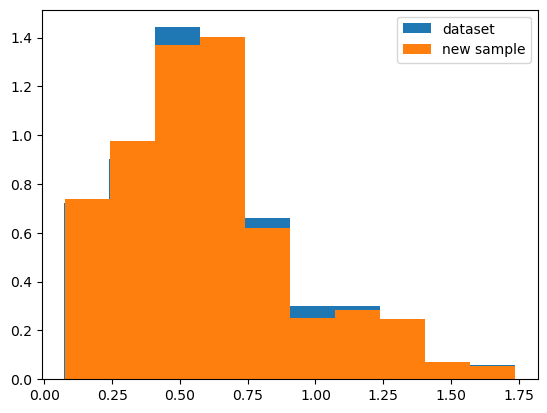

In [9]:
a0,b0,c0 = plt.hist(z_sample,density=True,label='dataset')
a1,b1,c1=plt.hist(sample_new,density=True,label='new sample')
plt.legend()
plt.show()

In [10]:
# new sample: the model gives us mu and sigma! generate the new sample as a random point drawn from a gaussian with mu and sigma

In [11]:
mu, std_prediction = gp.predict(sample_new[:, np.newaxis], return_std=True)
y_pred = np.random.normal(loc=mu,scale=std_prediction)

In [12]:
#sort data to plot it
x, y, err = zip(*sorted(zip(sample_new,y_pred,std_prediction)))
x = np.array(x)
y = np.array(y)
err = np.array(err)

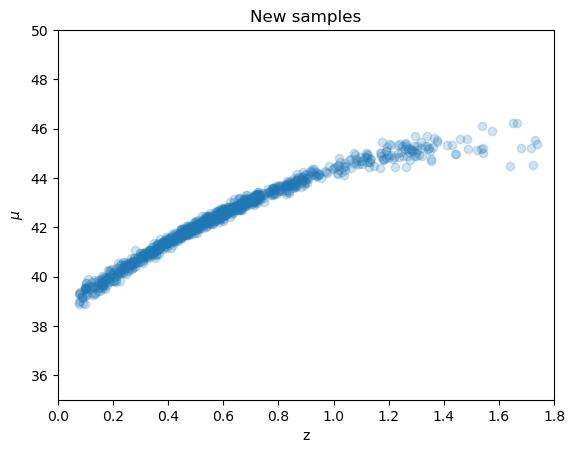

In [13]:
plt.scatter(x, y, alpha=0.2)
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,1.8)
plt.ylim(35,50)
plt.title('New samples')
plt.show()

# $\Lambda$CDM

$\mu = 5log\left(\frac{c/H_0}{10pc}(1+z)\int_{0}^{z}\frac{dz'}{\sqrt{\Omega_m(1+z^3)+\Omega_\Lambda)}}\right)$

In [14]:
def integral(x,a):
    return 1/np.sqrt(a*(1+x**3)+1-a)  # function to integrate

def integ(z,omega_m):
    i = []
    for z in z:
        x = z*np.random.rand(10000)       # I generate random numbers in a box: x in [0,z], since I am evualuating the integral in this interval
        y = np.random.rand(10000)         # y in [0,1], possible values for the function f to integrate
        x_ok = x[y<=integral(x,omega_m)] # I keep only those values such that y<f(x)
        y_ok = y[y<=integral(x,omega_m)]

        # (number of generated couples) / (number of ok couples) = (area of the box) / (integral)
        i.append((np.max(x)-np.min(x))*(np.max(y)-np.min(y))*np.size(x_ok)/np.size(x))
    
    return np.array(i)

def mu(z,H0,omega_m):
    return 5*np.log10(2.99*10**5/H0/10**(-5)*(1+z)*integ(z,omega_m))

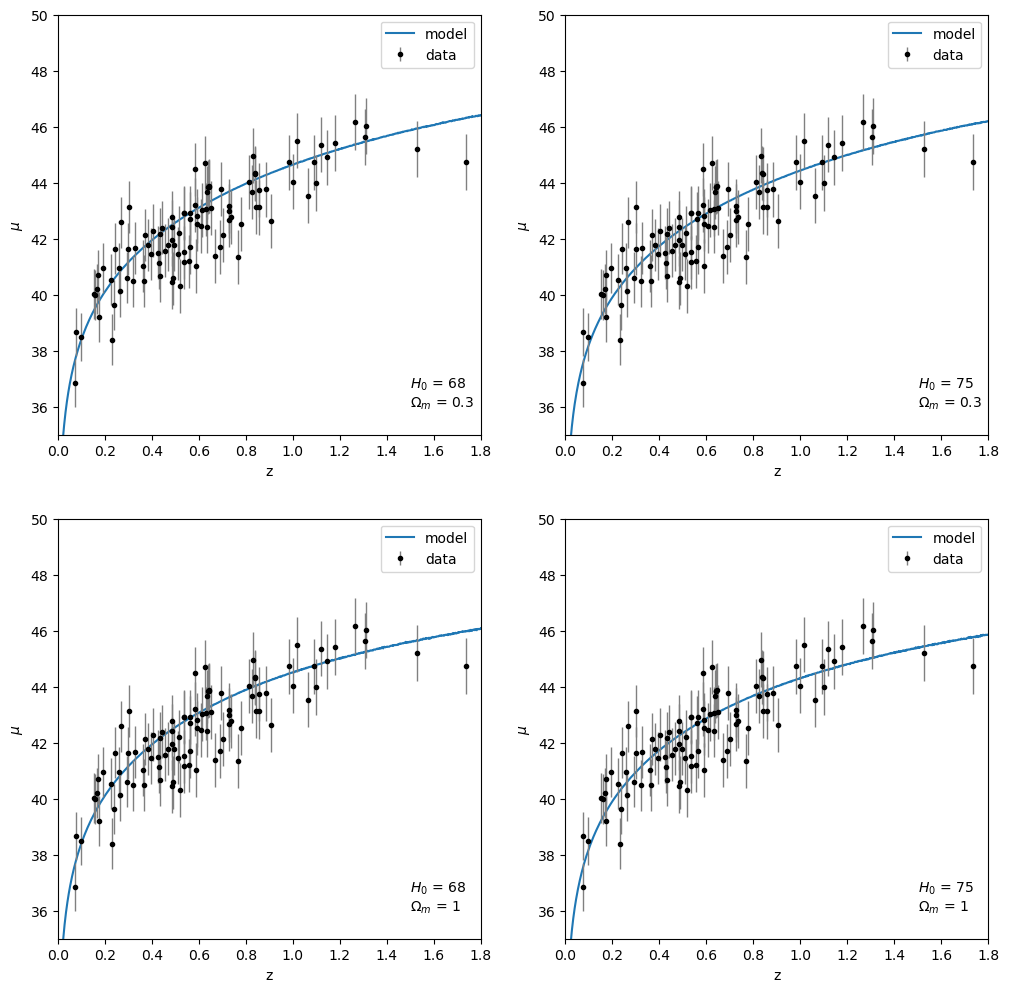

In [15]:
fig,axes = plt.subplots(2,2,figsize=(12,12))
x_plot = np.linspace(0.01,2,1000)

axes[0,0].plot(x_plot,mu(x_plot,68,0.3),label='model')
axes[0,0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[0,0].text(1.5,36,r"$H_0$ = "+str(68)+'\n'+r"$\Omega_m$ = "+str(0.3))
axes[0,0].set_xlabel("z")
axes[0,0].set_ylabel(r"$\mu$")
axes[0,0].set_xlim(0,1.8)
axes[0,0].set_ylim(35,50)
axes[0,0].legend()

axes[0,1].plot(x_plot,mu(x_plot,75,0.3),label='model')
axes[0,1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[0,1].text(1.5,36,r"$H_0$ = "+str(75)+'\n'+r"$\Omega_m$ = "+str(0.3))
axes[0,1].set_xlabel("z")
axes[0,1].set_ylabel(r"$\mu$")
axes[0,1].set_xlim(0,1.8)
axes[0,1].set_ylim(35,50)
axes[0,1].legend()

axes[1,0].plot(x_plot,mu(x_plot,68,1),label='model')
axes[1,0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[1,0].text(1.5,36,r"$H_0$ = "+str(68)+'\n'+r"$\Omega_m$ = "+str(1))
axes[1,0].set_xlabel("z")
axes[1,0].set_ylabel(r"$\mu$")
axes[1,0].set_xlim(0,1.8)
axes[1,0].set_ylim(35,50)
axes[1,0].legend()

axes[1,1].plot(x_plot,mu(x_plot,75,1),label='model')
axes[1,1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[1,1].text(1.5,36,r"$H_0$ = "+str(75)+'\n'+r"$\Omega_m$ = "+str(1))
axes[1,1].set_xlabel("z")
axes[1,1].set_ylabel(r"$\mu$")
axes[1,1].set_xlim(0,1.8)
axes[1,1].set_ylim(35,50)
axes[1,1].legend()

plt.show()

To fit the model to the data we use nested sampling.

## Model 1: $\Omega_m$ and $\Omega_{\Lambda}$

In [16]:
# p = [H0, omega_m]

def model_1(p,x):
    return mu(x,p[0],p[1])
    
def prior_1(p):
    prior_H = (100-50)*p[0]+50             # uniform [50,100]
    prior_omega = (1-0.1)*p[1]+0.1         # uniform [0.1,1]
    return [prior_H,prior_omega]

def log_likelihood_1(p,x,y,yerr):  #likelihood = prod(exp(-(y-model**2)/sigma**2)/(2*pi*sigma**2))
    return -0.5*np.sum((y-model_1(p,x))**2/yerr**2+np.log(2*np.pi*yerr**2))

In [17]:
ndim = 2
sampler_1 = dynesty.NestedSampler(log_likelihood_1, prior_1, ndim=ndim, logl_args=[z_sample,mu_sample,dmu])
sampler_1.run_nested()
sresults_1 = sampler_1.results

1387it [08:43,  2.65it/s, +500 | bound: 0 | nc: 1 | ncall: 8782 | eff(%): 22.784 | loglstar:   -inf < -133.734 <    inf | logz: -135.648 +/-  0.029 | dlogz:  0.001 >  0.509]


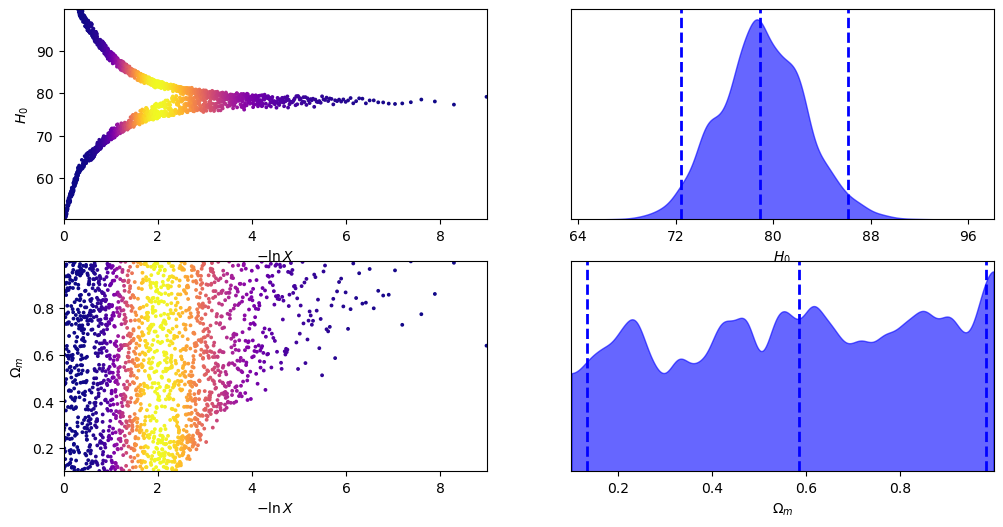

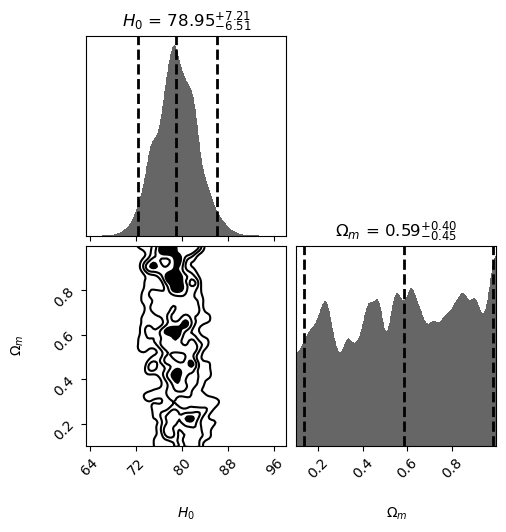

In [18]:
labels = [r"$H_0$",r"$\Omega_m$"]
tfig, taxes = dyplot.traceplot(sresults_1,labels=labels)
cfig, caxes = dyplot.cornerplot(sresults_1,show_titles=True, labels=labels)

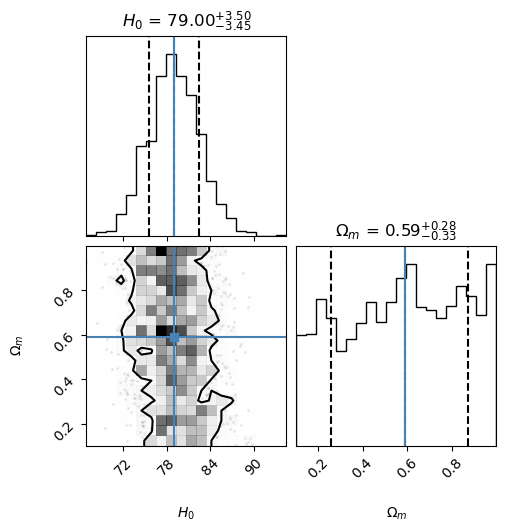

In [19]:
weights = np.exp(sresults_1.logwt - sresults_1.logz[-1])
samples = sresults_1.samples
samples_equal_1 = dyfunc.resample_equal(samples, weights) #Resample weighted samples
medians_1 = np.median(samples_equal_1,0)

fig = corner.corner(samples_equal_1, levels=[0.9],labels=labels,
                    truths=medians_1,show_titles=True,quantiles=[0.16,0.5,0.84])

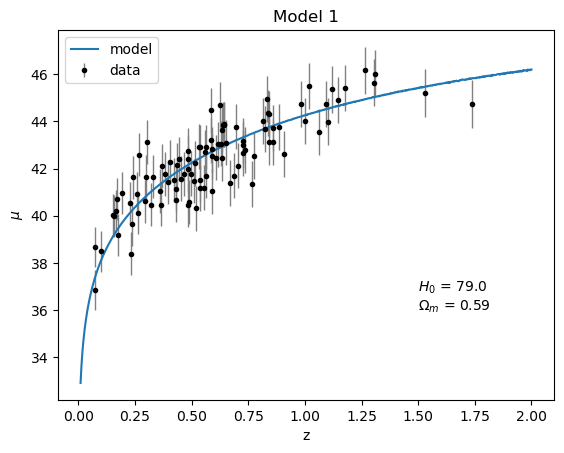

In [20]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_plot,mu(x_plot,medians_1[0],medians_1[1]),label='model')
plt.legend()
plt.text(1.5,36,r"$H_0$ = "+str(np.round(medians_1[0],2))+'\n'+r"$\Omega_m$ = "+str(np.round(medians_1[1],2)))
plt.title('Model 1')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.show()

## Model 2: $\Omega_m$ only

In [21]:
# p = [H0]

def model_2(p,x):
    return mu(x,p[0],1)
    
def prior_2(p):
    prior_H = (100-50)*p[0]+50  # uniform [50,100]
    return [prior_H]

def log_likelihood_2(p,x,y,yerr):  #likelihood = prod(exp(-(y-model**2)/sigma**2)/(2*pi*sigma**2))
    return -0.5*np.sum((y-model_2(p,x))**2/yerr**2+np.log(2*np.pi*yerr**2))

In [22]:
ndim = 1
sampler_2 = dynesty.NestedSampler(log_likelihood_2, prior_2, ndim=ndim, logl_args=[z_sample,mu_sample,dmu])
sampler_2.run_nested()
sresults_2 = sampler_2.results

1363it [07:59,  2.84it/s, +500 | bound: 0 | nc: 1 | ncall: 7831 | eff(%): 25.413 | loglstar:   -inf < -133.696 <    inf | logz: -135.557 +/-  0.027 | dlogz:  0.001 >  0.509]


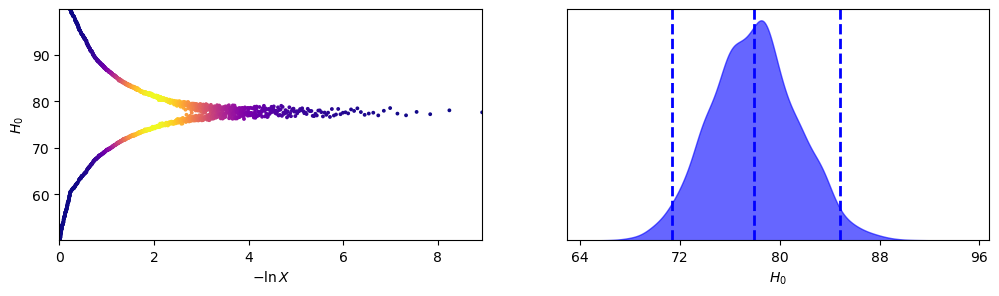

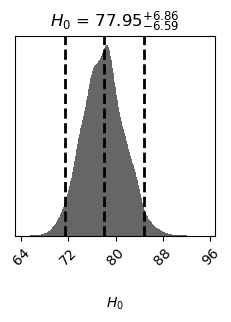

In [23]:
labels = [r"$H_0$"]
tfig, taxes = dyplot.traceplot(sresults_2,labels=labels)
cfig, caxes = dyplot.cornerplot(sresults_2,show_titles=True, labels=labels)

In [24]:
weights = np.exp(sresults_2.logwt - sresults_2.logz[-1])
samples = sresults_2.samples
samples_equal_2 = dyfunc.resample_equal(samples, weights) #Resample weighted samples
medians_2 = np.median(samples_equal_2,0)

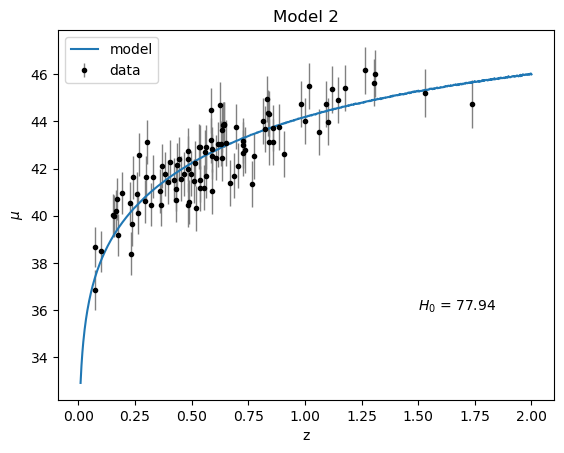

In [25]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_plot,mu(x_plot,medians_1[0],1),label='model')
plt.legend()
plt.text(1.5,36,r"$H_0$ = "+str(np.round(medians_2[0],2)))
plt.title('Model 2')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.show()

## Comparison: Bayesian ratio

In [26]:
b = np.exp(sresults_1.logz[-1])/np.exp(sresults_2.logz[-1])
print('Bayes factor = ', b)
print('The second model is preferred')

Bayes factor =  0.9123660990745833
The second model is preferred
